In [17]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [18]:
PATH_TO_DATA = '/content/drive/MyDrive/go_algo/data/'
df = pd.read_csv(PATH_TO_DATA + 'flot_tradestats.csv')

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df['target'].describe()

count    11962.000000
mean        -0.042033
std          0.681318
min         -7.710000
25%         -0.280000
50%         -0.050000
75%          0.180000
max          9.490000
Name: target, dtype: float64

In [21]:
df = df.drop(['Unnamed: 0'],axis=1)
df_numpy = df.to_numpy()
feature_sc = MinMaxScaler(feature_range=(-1,1))
df_numpy_scaled = feature_sc.fit_transform(df_numpy)

In [22]:
X = []
windows = 10
cols = df_numpy_scaled.shape[1]

for j in range(cols):
  X.append([])
  for i in range(windows, df_numpy_scaled.shape[0]):
    X[j].append(df_numpy_scaled[i-windows:i, j])

X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(df_numpy_scaled[windows:,-1])
y=np.reshape(yi,(len(yi),1))

In [23]:
splitlimit = int(X.shape[0]*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([9561, 10, 20]),
 torch.Size([2391, 10, 20]),
 torch.Size([9561, 1]),
 torch.Size([2391, 1]))

In [24]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [26]:
class ChangeModel(nn.Module):
  def __init__(self,input_size, hidden_size,num_stacked_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_size = num_stacked_size
    self.lstm = nn.LSTM(input_size,hidden_size,num_stacked_size,batch_first=True)
    self.lin = nn.Linear(hidden_size,1)
  def forward(self,x):
    batch = x.size(0)
    h0 = torch.zeros(self.num_stacked_size,batch,self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_size,batch,self.hidden_size).to(device)
    out,_ =self.lstm(x,(h0,c0))
    out = self.lin(out[:,-1,:])
    return out

In [27]:
model = ChangeModel(20,4,1)
model.to(device)
epochs = 30
loss_function = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr = 0.01)
for epoch in range(epochs):
   model.train(True)
   print(f'Epoch: {epoch + 1}')
   running_loss = 0.0

   for batch_index, batch in enumerate(train_loader):
      x_batch, y_batch = batch[0].to(device), batch[1].to(device)

      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

      optim.zero_grad()
      loss.backward()
      optim.step()

      if batch_index % 100 == 99:  # print every 100 batches
          avg_loss_across_batches = running_loss / 100
          print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
      running_loss = 0.0
   print()

   model.train(False)
   running_loss = 0.0

   for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

   avg_loss_across_batches = running_loss / len(test_loader)

   print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
   print('***************************************************')
   print()


Epoch: 1
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.003
***************************************************

Epoch: 2
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.002
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000

Val Loss: 0.001
***************************************************

Epoch: 6
Batch 100, Loss: 0.00

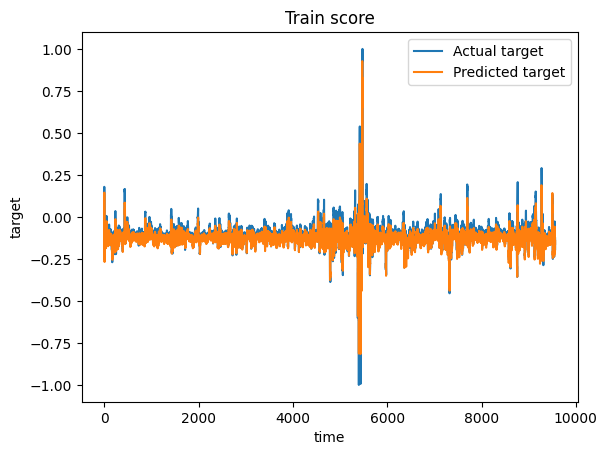

In [28]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.title('Train score')
plt.plot(y_train, label='Actual target')
plt.plot(predicted, label='Predicted target')
plt.xlabel('time')
plt.ylabel('target')
plt.legend()
plt.show()

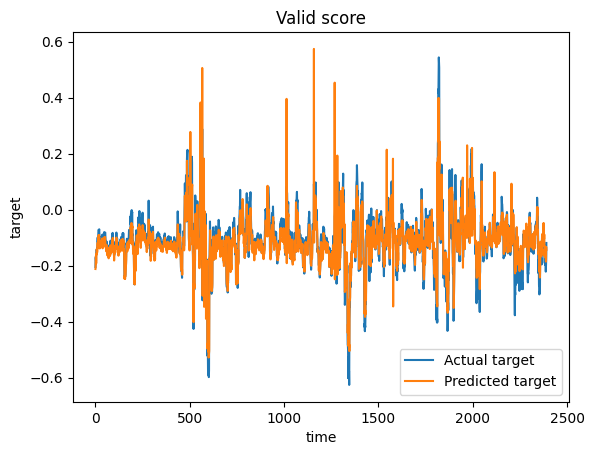

In [29]:
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.title('Valid score')
plt.plot(y_test, label='Actual target')
plt.plot(predicted, label='Predicted target')
plt.xlabel('time')
plt.ylabel('target')
plt.legend()
plt.show()

In [30]:
PATH_TO_MODEL = '/content/drive/MyDrive/go_algo/data/models/'
torch.save(model,PATH_TO_MODEL+'flot_model.pt')

In [31]:
test_model = ChangeModel(20,4,1)
test_model = torch.load(PATH_TO_MODEL+'flot_model.pt')
test_model.eval()

ChangeModel(
  (lstm): LSTM(20, 4, batch_first=True)
  (lin): Linear(in_features=4, out_features=1, bias=True)
)